# Исследовательский анализ данных

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.



### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [306]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [307]:
contract = pd.read_csv('C:/отчеты/Яндекс/проекты/Финальный проект/contract.csv')
pesonal = pd.read_csv('C:/отчеты/Яндекс/проекты/Финальный проект/personal.csv')
phone = pd.read_csv('C:/отчеты/Яндекс/проекты/Финальный проект/phone.csv')
internet = pd.read_csv('C:/отчеты/Яндекс/проекты/Финальный проект/internet.csv')

In [308]:
#data_list = [contract, pesonal, phone, internet]

In [309]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [310]:
pesonal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [311]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [312]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [313]:
def find_duplicates_by_columns(df):  # функция для поиска дубликатов по столбцам
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

In [314]:
def missing_data(data):  # функция для поиска пропусков
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).head(40)

In [315]:
find_duplicates_by_columns(contract)

,column,duplicates
4,PaperlessBilling,7041
3,Type,7040
5,PaymentMethod,7039
2,EndDate,7038
1,BeginDate,6966
6,MonthlyCharges,5458
7,TotalCharges,512
0,customerID,0


In [316]:
find_duplicates_by_columns(pesonal)

,column,duplicates
1,gender,7041
2,SeniorCitizen,7041
3,Partner,7041
4,Dependents,7041
0,customerID,0


In [317]:
find_duplicates_by_columns(phone)

,column,duplicates
1,MultipleLines,6359
0,customerID,0


In [318]:
find_duplicates_by_columns(internet)

,column,duplicates
1,InternetService,5515
2,OnlineSecurity,5515
3,OnlineBackup,5515
4,DeviceProtection,5515
5,TechSupport,5515
6,StreamingTV,5515
7,StreamingMovies,5515
0,customerID,0


При рассмотрении данных по отдельности, ни в одном датафрейме не было найдено пропусков и повторяющихся id клиентов. 

##### Объединение данных

In [319]:
data_2 = contract.merge(pesonal, on = 'customerID', how = 'outer')

In [320]:

data_3 = data_2.merge(phone, on = 'customerID', how = 'outer')

In [321]:
missing_data(data_3)

,Total,Percent
MultipleLines,682,9.683374
Dependents,0,0.000000
Partner,0,0.000000
SeniorCitizen,0,0.000000
gender,0,0.000000
TotalCharges,0,0.000000
MonthlyCharges,0,0.000000
PaymentMethod,0,0.000000
PaperlessBilling,0,0.000000
Type,0,0.000000


682 пропуска соответсвуют количеству клиентов, на которых нет информации о многоканальном телефоне, следовательно датафремы на данном этапе соедиены корректно

In [322]:
data = data_3.merge(internet, on = 'customerID', how = 'outer')

In [323]:
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No


Проверим объединенный датасет на пропуски и повторяющиеся значения 

In [324]:
find_duplicates_by_columns(data)

,column,duplicates
10,Partner,7041
4,PaperlessBilling,7041
8,gender,7041
9,SeniorCitizen,7041
11,Dependents,7041
12,MultipleLines,7040
18,StreamingTV,7040
17,TechSupport,7040
16,DeviceProtection,7040
15,OnlineBackup,7040


Дубликатов по клиентам нет. Вся остальная информация может повторяться 

In [325]:
missing_data(data)

,Total,Percent
StreamingMovies,1526,21.666903
TechSupport,1526,21.666903
DeviceProtection,1526,21.666903
OnlineBackup,1526,21.666903
OnlineSecurity,1526,21.666903
InternetService,1526,21.666903
StreamingTV,1526,21.666903
MultipleLines,682,9.683374
PaymentMethod,0,0.000000
BeginDate,0,0.000000


Количество пропусков по столбцам соответсвет количеству отсутствующей информации о каждом клиентае на основе исходых данных

#### Анализ целевого признака

Целевой признак EndDate. Для наглядности добавлю еще один бинарный столбец соответсвующий EndDate

In [326]:
lost_client = []
for i in data['EndDate']:
    if i == 'No':
        lost_client.append(0)
    else:
        lost_client.append(1)
        

In [327]:
lost_client = pd.Series(lost_client)

In [328]:
data['lost_client'] = lost_client

In [329]:
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,lost_client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,Yes,NaN,DSL,Yes,No,No,No,No,No,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,...,No,Yes,Fiber optic,No,No,No,No,No,No,1


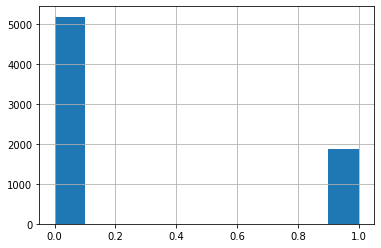

In [330]:
data['lost_client'].hist()

Как видно из гистограммы, ушедших клиентов более чем в два раза меньше, что говорит о дисбалансе классов. В дальнейшем дизбаланс классов должен быть устранен, например с помощтю SMOTE. 

# Вывод 

В рамках исследовательского анализа выяснилось:
       1. В отдельных датасетах не обнаружилось критических проблем, однако данные каждого признака требуют более детального                   изучения в рамках предобработки данных 
       2. Чтобы более подробно изучить корреляции между признаками, данные должны пройти предобработку, признаки по возможности долны быть переведены в количественные 
       3. Был обнаружен дисбаланс классов целевой переменной, который должен быть устренен
       

#### План достижения цели проекта: 

1. Провести предобработку данных
2. Найти значимые закономерности и корреляции между признаками 
3. Обучить модели машинного обучения
4. Протестировать модели
5. Написать Вывод и сделать отчет о проделанной работе 

# Предобработка данных


In [331]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
lost_client         7043 non-null int64
dtypes: float64(1), int64(2), obj

In [332]:
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,lost_client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,Yes,NaN,DSL,Yes,No,No,No,No,No,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,...,No,Yes,Fiber optic,No,No,No,No,No,No,1


In [333]:
#рассмотрим уникальные значения для каждого столбца 
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11

### Работа с фичами

In [334]:
# Создадим признок продолжительности обслуживания клиентов, но для начала переведем в date-time имеющиеся столбцы с датами
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format = '%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'],format = '%Y-%m-%d', errors ='coerce') #coerce замегит Nan на NaT
data['Service_period'] = data['EndDate'] - data['BeginDate']

In [335]:
# Заменим пропуски полученного признака Service_period на количество дней равное 01.02.2020 минус дата начала пользования 
#создам маску, указывающую на Nat в Service_period
mask = data['Service_period'].isna()
for i in range(len(mask)):
    if mask[i] == True: 
        data.loc[i, 'Service_period'] = pd.to_datetime('2020-02-01', format = '%Y-%m-%d') - data.loc[i,'BeginDate']
        

In [336]:
#поменяю тип Service_period в int, сделва дни числами
data['Service_period'] = (data['Service_period']/ np.timedelta64(1, 'D')).astype('int')

Удалю даты , чтобы не возникала проблема мультиколлинеарности, т.к уже присутствуют признак Service_period. EndDate тоже удалю, т.к. это  целевой признак.

In [337]:
#data = data.drop(['BeginDate'], axis = 1)
data = data.drop(['EndDate'], axis = 1)

### Изменение типов  

In [338]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

### Заполнение пропусков

In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
lost_client         7043 non-null int64
Service_period      7043 non-null int32
dtypes: datetime64[ns](1)

In [340]:
missing_data(data)

,Total,Percent
StreamingMovies,1526,21.666903
StreamingTV,1526,21.666903
TechSupport,1526,21.666903
DeviceProtection,1526,21.666903
OnlineBackup,1526,21.666903
OnlineSecurity,1526,21.666903
InternetService,1526,21.666903
MultipleLines,682,9.683374
TotalCharges,11,0.156183
Service_period,0,0.000000


In [341]:
#заполню пропуски в EndDate одним чилом, которое на несколько лет больше 01.02.2020. Пусть это будет 01.02.2025. Так я отдельно
#выделю людей, которые еще не ушли из компании
#data['EndDate'] = pd.to_datetime(data['EndDate'].fillna('2025-02-01'), format = '%Y-%m-%d')   

Все остальные пропуски я заполню выделяющимся от всех значением -1

In [342]:
data['StreamingMovies'] = data['StreamingMovies'].fillna(-1)
data['StreamingTV'] = data['StreamingTV'].fillna(-1)
data['TechSupport'] = data['TechSupport'].fillna(-1)
data['DeviceProtection'] = data['DeviceProtection'].fillna(-1)
data['OnlineBackup'] = data['OnlineBackup'].fillna(-1)
data['OnlineSecurity'] = data['OnlineSecurity'].fillna(-1)
data['InternetService'] = data['InternetService'].fillna(-1)
data['MultipleLines'] = data['MultipleLines'].fillna(-1)
data['TotalCharges'] = data['TotalCharges'].fillna(-1)

In [343]:
data.head()

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,lost_client,Service_period
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,-1,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,No,DSL,Yes,Yes,No,No,No,No,1,61
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,-1,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,No,Fiber optic,No,No,No,No,No,No,1,61


### Кодирование

C помощью Label Encoder я закодирую 1 или 0 значения категориальных признаков, у которых только два варианта значения
C помощью OHE я закодирую признаки, у которых значений больше, чем 2

Это я делаю чтобы модель при обучении не искала лишних зависимостей

In [344]:
def encode(data):
    le = LabelEncoder()
    for col in ['PaperlessBilling', 'gender', 
                'Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies']:
        data[col] = le.fit_transform(data[col].astype('str')) # label encoder
    data = pd.get_dummies(data, columns = ['Type', 'PaymentMethod', 'InternetService']) # ohe 
   
    return data  

In [345]:
data_enc = encode(data)

In [346]:
data_enc.head()

,customerID,BeginDate,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_-1,InternetService_DSL,InternetService_Fiber optic
0,7590-VHVEG,2020-01-01,1,29.85,29.85,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
1,5575-GNVDE,2017-04-01,0,56.95,1889.50,1,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
2,3668-QPYBK,2019-10-01,1,53.85,108.15,1,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
3,7795-CFOCW,2016-05-01,0,42.30,1840.75,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
4,9237-HQITU,2019-09-01,1,70.70,151.65,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1


Cтолбец customerID больше не понадобится т.к. все данные уже соединены. Для сохранения соответсвия индексов датасета и ID пользователей сохраню Series с СustomerID

In [347]:
CustomerID = data['customerID']

In [348]:
data_enc = data_enc.drop(['customerID'], axis = 1)

In [361]:
data_enc = data_enc.drop(['BeginDate'], axis = 1) #удалил столбец с датами, т.к. LightGBM их не примет

In [362]:
data = data.drop(['customerID'], axis = 1)

KeyError: "['customerID'] not found in axis"

### Оптимизация памяти

In [363]:
#Функция для уменьшения объема хранения в памяти:
def reduce_mem_usage(df, verbose=True, not_used_cols = []):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col not in not_used_cols:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Память хранения уменьшена с {:5.2f} Mb до {:5.2f} Mb, итого ({:.1f}% уменьшения)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [364]:
data = reduce_mem_usage(data)

Память хранения уменьшена с  0.71 Mb до  0.71 Mb, итого (0.0% уменьшения)


In [365]:
data_enc = reduce_mem_usage(data_enc)

Память хранения уменьшена с  0.56 Mb до  0.56 Mb, итого (0.0% уменьшения)


## Вывод

    
    В рамках предобработки данных было сделано следующее:
        1. Был учтен новый признак lost_client в качестве целевого
        2. EndDate был удален. 
        3. Был добавлен новый признак времени жизни клиента Service_period
        4. Столбец с id клиентов был удален из данных по ненадобности, но сохранен Series соответсвия индексов data и ID клиентов
        5. Все пропуски были заполнены -1
        4. Датасет был закодирован для обучения  LigtGBM. C помощью Label Encoder я закодировал 1 или 0 значения       категориальных признаков, у которых только два варианта значения. C помощью OHE я закодировал признаки, у которых значений больше, чем 2. Это я сделал, чтобы модель при обучении не искала лишних зависимостей. Для данных для обучения LightGBM (data_enc) все признаки с датами были удалены т.к. datetime он не принимает.
        5. Для Catboost я использовал некодированные данные с признаком типа datetime BeginDate
        6. Был сокращен объем памяти хранения
    

## Разделение

#### Без кодировки

In [367]:
train, others = train_test_split(data, test_size=0.40, random_state=12345)
test, valid = train_test_split(others, test_size = 0.50, random_state = 12345)

In [368]:
train_features = train.drop(['lost_client'], axis = 1)
train_target = train['lost_client']


valid_features = valid.drop(['lost_client'], axis = 1)
valid_target = valid['lost_client']

test_features = test.drop(['lost_client'], axis = 1)
test_target = test['lost_client']



In [369]:
train_features.head(5)

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Service_period
836,2014-12-01,One year,0,Credit card (automatic),71.375000,4488.000000,1,0,1,1,1,DSL,2,1,2,2,1,2,1888
1005,2015-09-01,One year,1,Credit card (automatic),95.875000,5016.000000,0,1,1,0,2,Fiber optic,1,1,1,1,2,2,1614
4220,2015-07-01,One year,0,Mailed check,19.500000,1026.000000,1,0,1,1,1,-1,0,0,0,0,0,0,1676
6543,2014-12-01,One year,0,Credit card (automatic),54.750000,3426.000000,0,0,1,1,1,DSL,2,1,2,1,1,1,1888
272,2019-11-01,Month-to-month,0,Bank transfer (automatic),24.796875,24.796875,1,0,0,0,0,DSL,1,1,1,1,1,1,30


#### С кодировкой

In [370]:
train_enc, others_enc = train_test_split(data_enc, test_size=0.40, random_state=12345)
test_enc, valid_enc = train_test_split(others_enc, test_size = 0.50, random_state = 12345)

In [371]:
train_features_enc = train_enc.drop(['lost_client'], axis = 1)
train_target_enc = train_enc['lost_client']


valid_features_enc = valid_enc.drop(['lost_client'], axis = 1)
valid_target_enc = valid_enc['lost_client']

test_features_enc = test_enc.drop(['lost_client'], axis = 1)
test_target_enc = test_enc['lost_client']


In [372]:
train_features_enc.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_-1,InternetService_DSL,InternetService_Fiber optic
836,0,71.375000,4488.000000,1,0,1,1,1,2,1,...,0,1,0,0,1,0,0,0,1,0
1005,1,95.875000,5016.000000,0,1,1,0,2,1,1,...,0,1,0,0,1,0,0,0,0,1
4220,0,19.500000,1026.000000,1,0,1,1,1,0,0,...,0,1,0,0,0,0,1,1,0,0
6543,0,54.750000,3426.000000,0,0,1,1,1,2,1,...,0,1,0,0,1,0,0,0,1,0
272,0,24.796875,24.796875,1,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0


## Обучение моделей

### LightGBM

In [384]:
%%time
LGBM_Classifier = LGBMClassifier()
LGBM_Classifier.fit(train_features_enc, train_target_enc)
pred_LGBM_Classifier= LGBM_Classifier.predict(test_features_enc)
score_LGBM_Classifier= roc_auc_score(test_target_enc, pred_LGBM_Classifier)
score_LGBM_Classifier

Wall time: 201 ms


0.7596325902210984

### Catboost

In [385]:
cat_features = ['Type', 'PaymentMethod', 'InternetService']

In [386]:
%%time
CatBoostClassifier_model = CatBoostClassifier()
CatBoostClassifier_model.fit(train_features, train_target, cat_features=cat_features, verbose=20)
pred_CatBoostClassifier_model = CatBoostClassifier_model.predict(valid_features)
score_CatBoostClassifier_model = roc_auc_score(valid_target, pred_CatBoostClassifier_model)
score_CatBoostClassifier_model

Learning rate set to 0.019062
0:	learn: 0.6796819	total: 18ms	remaining: 18s
20:	learn: 0.5068882	total: 362ms	remaining: 16.9s
40:	learn: 0.4217080	total: 595ms	remaining: 13.9s
60:	learn: 0.3761190	total: 932ms	remaining: 14.3s
80:	learn: 0.3513233	total: 1.24s	remaining: 14.1s
100:	learn: 0.3357951	total: 1.48s	remaining: 13.1s
120:	learn: 0.3191050	total: 1.88s	remaining: 13.7s
140:	learn: 0.3090666	total: 2.11s	remaining: 12.9s
160:	learn: 0.3007843	total: 2.4s	remaining: 12.5s
180:	learn: 0.2913137	total: 2.65s	remaining: 12s
200:	learn: 0.2821809	total: 2.93s	remaining: 11.6s
220:	learn: 0.2742855	total: 3.19s	remaining: 11.3s
240:	learn: 0.2687152	total: 3.4s	remaining: 10.7s
260:	learn: 0.2623435	total: 3.66s	remaining: 10.4s
280:	learn: 0.2560993	total: 3.89s	remaining: 9.96s
300:	learn: 0.2510325	total: 4.09s	remaining: 9.49s
320:	learn: 0.2444426	total: 4.32s	remaining: 9.14s
340:	learn: 0.2375847	total: 4.54s	remaining: 8.77s
360:	learn: 0.2327594	total: 4.78s	remaining: 8

0.9572538860103628

# Тестирование 

In [378]:
LGBM_Classifier_pred_test = LGBM_Classifier.predict(test_features_enc)

In [387]:
%%time
score_CatBoostClassifier_test = roc_auc_score(test_target_enc, LGBM_Classifier_pred_test)
score_CatBoostClassifier_test

Wall time: 3 ms


0.7596325902210984

In [382]:
CatBoostClassifier_model_test = CatBoostClassifier_model.predict(test_features)

In [388]:
%%time
score_CatBoostClassifier_model_test = roc_auc_score(test_target, CatBoostClassifier_model_test)
score_CatBoostClassifier_model

Wall time: 3 ms


0.9572538860103628

# Вывод

В рамках проекта были построены две модели на основе градиентного бустинга - модель LightGBM и Catboost. На тесте LightGBM достигла показателя ROC-AUC = 0.76 за 3 мс, Сatboost - ROC-AUC = 0.95 за 3мс. 
    Разница в качестве объясняется передачей сырых категориальных фич непосредственно в Catboost, а так же использованием признака BeginDate в формате datetime, который LightGBM не поддерживает.
